# Gaussian Processes

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

In [2]:
import pymc as pm
from pymc import gp

In [3]:
import pytensor
import pytensor.tensor as pt 

In [4]:
import arviz as az

In [5]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

In [6]:
plt.rc('font',   size=16)          # controls default text sizes
plt.rc('axes',   titlesize=20)     # fontsize of the axes title
plt.rc('axes',   labelsize=20)     # fontsize of the x and y labels
plt.rc('xtick',  labelsize=20)     # fontsize of the tick labels
plt.rc('ytick',  labelsize=20)     # fontsize of the tick labels
plt.rc('legend', fontsize=18)      # legend fontsize
plt.rc('figure', titlesize=18)     # fontsize of the figure title

## Versions

In [7]:
print("Numpy: ", np.__version__)
print("Scipy: ", sp.__version__)
print("Pandas: ", pd.__version__)
print("pymc: ", pm.__version__)
print("pytensor: ", pytensor.__version__)
print("arviz: ", az.__version__)

Numpy:  1.24.3
Scipy:  1.10.1
Pandas:  1.5.3
pymc:  5.3.0
pytensor:  2.11.1
arviz:  0.15.1


## Drawing posterior functions from a GP

Create a synthetic dataset:

In [8]:
rng = np.random.default_rng(1354)
x = np.linspace(0.1,10,20)
y = np.sin(x) / x + rng.normal(0, 0.1, len(x))

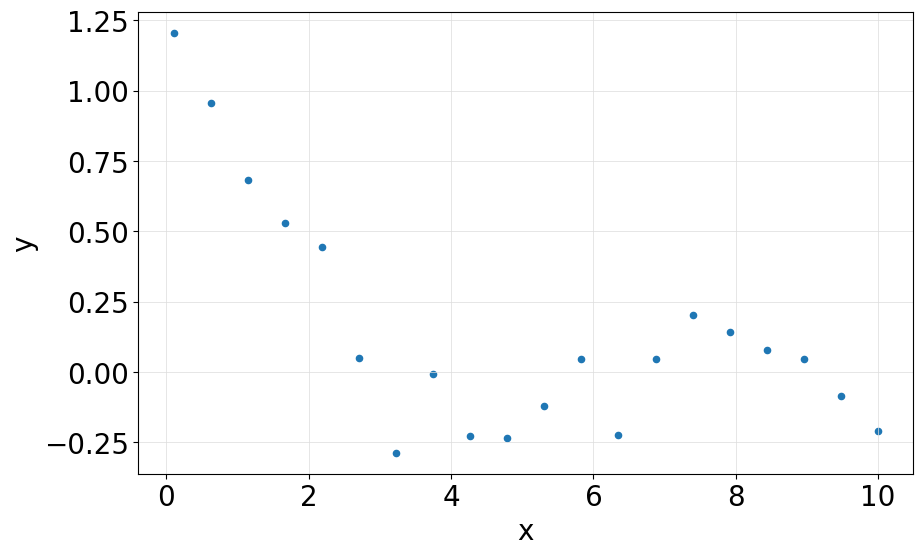

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.scatter(x,y,s=20)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

In [10]:
dim = 1                                             # This is a 1-dimensional problem
X = x.reshape((len(x),1))                           # marginal_likelihood expects a column vector, not a row vector

In [11]:
with pm.Model() as myModel:
    lam = pm.Gamma('lambda', 2, 0.5)
    covarianceFunction = gp.cov.ExpQuad(dim, ls=lam)
    myGP = gp.Marginal(cov_func = covarianceFunction)
    sigma = pm.HalfCauchy('sigma', 1)
    likelihood = myGP.marginal_likelihood('y', X=X, y=y, sigma=sigma)
    idata = pm.sample(2000, chains=4, cores=2, return_inferencedata=True)                  # inference data object

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [lambda, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


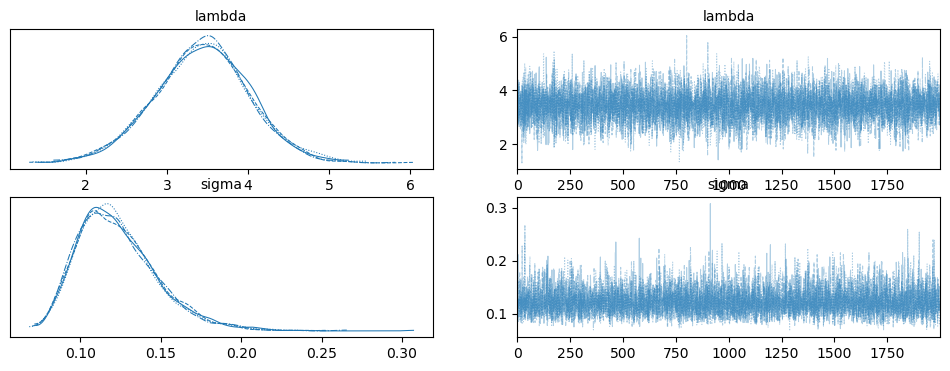

In [12]:
fig = az.plot_trace(idata)

In [13]:
az.summary(idata, hdi_prob=0.95, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,3.430,0.582,2.227,4.542,0.007,0.005,6726.717,4568.154,1.0
sigma,0.123,0.025,0.080,0.171,0.000,0.000,6962.188,5407.677,1.0


Find the Maximum A Posteriori values for the scale length $\lambda$ of our covariance function:

In [14]:
MAP = pm.find_MAP(model=myModel)
print("MAP scale length: ", MAP['lambda'])


MAP scale length:  3.4539920067609153


Compute the mean posterior $E[f(x^*)]$ manually:

In [15]:
Xnew = np.linspace(0.01, 15, 200).reshape((200,1))             # Column vector instead of row vector

In [16]:
N = len(x)
cov = gp.cov.ExpQuad(1, MAP['lambda'])
K = cov(X)
Kstar = cov(X, Xnew)
Knoise = K + MAP['sigma'] * np.eye(N)

L = np.linalg.cholesky(Knoise.eval())
A = np.linalg.solve(L.T, np.linalg.solve(L, y))
meanPosterior = Kstar.T.eval() @ A

Sample the Gaussian process for a few functions which we will also plot. By default `pm.sample_posterior_predictive()` samples as many functions as there are points in the trace which is too much. We therefore only select every 100th point of the trace and continue with this. This will leave us with about 20 posterior predictve sampled functions `f`. 

In [17]:
with myModel:
    f = myGP.conditional('f', Xnew)
    thinned = idata.sel(draw=slice(None, None, 100))                                                      # Only for every 100th point. To speed up, and to make the plot more clear.
    idata.extend(pm.sample_posterior_predictive(thinned, var_names=['f']))

Sampling: [f]


`idata.posterior_predictive.f` now contains function `f` evaluations for each of the 200 `Xnew` points. However it is stored in a somewhat impractical way: as a `(4, 20, 200)` array. 4 because we used 4 chains, 20 is the number of sampled functions for each of our chain, and 200 the number of x-values in which we evaluate `f`. In the following we merge all the 4 chains together:

In [18]:
Nchains, Nsamples, Nxvalues = idata.posterior_predictive.f.shape
post_pred_dist = np.array(idata.posterior_predictive.f).transpose().reshape(Nxvalues, Nchains*Nsamples)

Now we can plot each of the 4*20 = 80 posterior predictive functions:

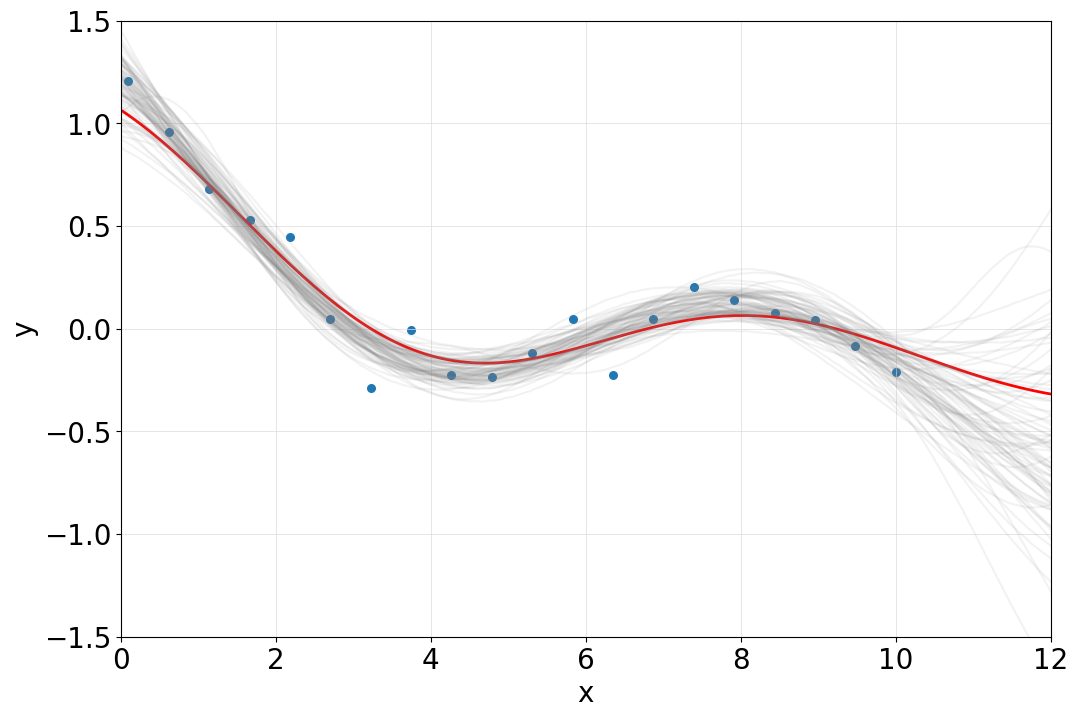

In [19]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.plot(Xnew, meanPosterior, c='red', linewidth=2)
ax.scatter(x,y,s=30,c="C0")
plt.plot(Xnew, post_pred_dist, c='grey', alpha=0.1)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
ax.set_xlim(0, 12)
ax.set_ylim(-1.5, 1.5)
plt.show()

## Another example

#### Create a dataset

In [20]:
rng = np.random.default_rng(13534)

x = np.linspace(0, 1, 100)
ytrue = np.sin(2*np.pi*x) + np.sin(7*np.pi*x)
y = ytrue + rng.normal(0.0, 0.3, len(x))

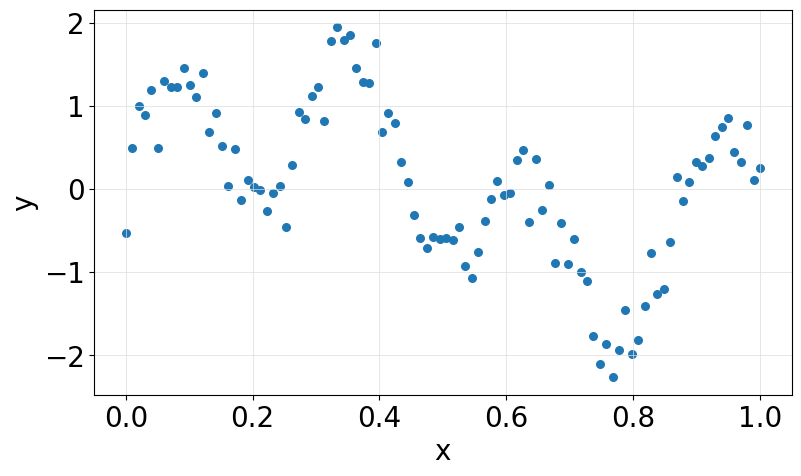

In [21]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
ax.scatter(x,y,s=30,c="C0")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### Put the GP fitting into a function 

In [22]:
def fitGP(x, y, lamda, xnew):
    
    dim = 1                                      # This is a 1-dimensional problem
    X = x.reshape((len(x),1))                    # marginal_likelihood expects a column vector, not a row vector
    Xnew = xnew.reshape((len(xnew),1))

    # Fit the GP model
    
    with pm.Model() as myModel:
        sigmaCovFunction = pm.HalfCauchy('sigma_cov', 5)
        covarianceFunction = gp.cov.Constant(sigmaCovFunction) * gp.cov.ExpQuad(dim, ls=lamda)
        myGP = gp.Marginal(cov_func = covarianceFunction)
        sigmaNoise = pm.HalfCauchy('sigma', 1)
        likelihood = myGP.marginal_likelihood('y', X=X, y=y, sigma=sigmaNoise)
        idata = pm.sample(chains=3, cores=2, return_inferencedata=True)
   
    # Estimate the posterior predictive distribution
    
    with myModel:
        f = myGP.conditional('f', Xnew)
        thinned = idata.sel(draw=slice(None, None, 50))                                                      # Only for every 50th point. To speed up things.
        idata.extend(pm.sample_posterior_predictive(thinned, var_names=['f']))
    
    return myModel, idata

‼️ Note: the `marginal_likelihood()` function does not accept Pandas vectors; it does accept NumPy arrays. 

#### Try $\lambda = 1$

In [23]:
Xnew = np.linspace(0,1,40)
model, idata = fitGP(x, y, 1.0, Xnew)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma_cov, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 598 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f]


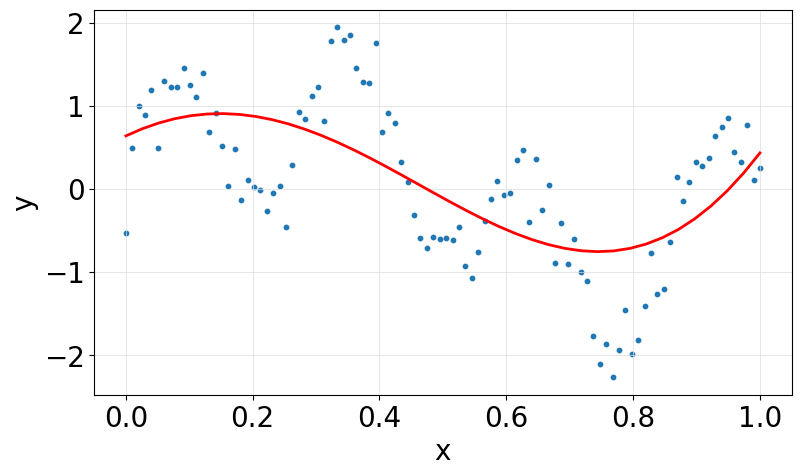

In [24]:
fig, ax = plt.subplots(1,1, figsize=(9,5))

meanPosterior = np.array(idata.posterior_predictive.f.mean(axis=(0,1)))                # Average over all samples and chains

plt.plot(Xnew, meanPosterior, c='red', linewidth=2)
ax.scatter(x,y,s=10,c="C0")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### Try $\lambda = 0.001$

In [25]:
model, idata = fitGP(x, y, 0.001, Xnew)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma_cov, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 618 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f]


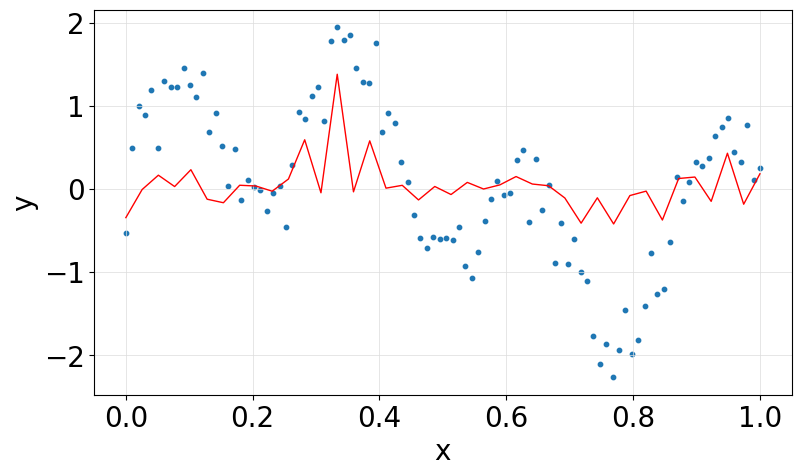

In [26]:
fig, ax = plt.subplots(1,1, figsize=(9,5))

meanPosterior = np.array(idata.posterior_predictive.f.mean(axis=(0,1)))                # Average over all samples and chains

plt.plot(Xnew, meanPosterior, c='red', linewidth=1)
ax.scatter(x,y,s=10,c="C0")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

#### Include $\lambda$ in the probabilistic model 

In [27]:
dim = 1                                       # This is a 1-dimensional problem
X = x.reshape((len(x),1))                     # marginal_likelihood expects a column vector, not a row vector
Xnew = np.linspace(0,1,80).reshape(80,1)

with pm.Model() as myModel:
     lamda = pm.Gamma('lambda', 2, 0.5)
     sigmaCovFunction = pm.HalfCauchy('sigma_cov', 5)
     covarianceFunction = gp.cov.Constant(sigmaCovFunction) * gp.cov.ExpQuad(dim, ls=lamda)
     myGP = gp.Marginal(cov_func = covarianceFunction)
     sigmaNoise = pm.HalfCauchy('sigma', 1)
     likelihood = myGP.marginal_likelihood('y', X=X, y=y, sigma=sigmaNoise)

     idata = pm.sample(chains=3, cores=2, return_inferencedata=True)
       

with myModel:
     f = myGP.conditional('f', Xnew)
     thinned = idata.sel(draw=slice(None, None, 50))        # Only for every 50th point. To speed up things.
     idata.extend(pm.sample_posterior_predictive(thinned, var_names=['f']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [lambda, sigma_cov, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 747 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f]


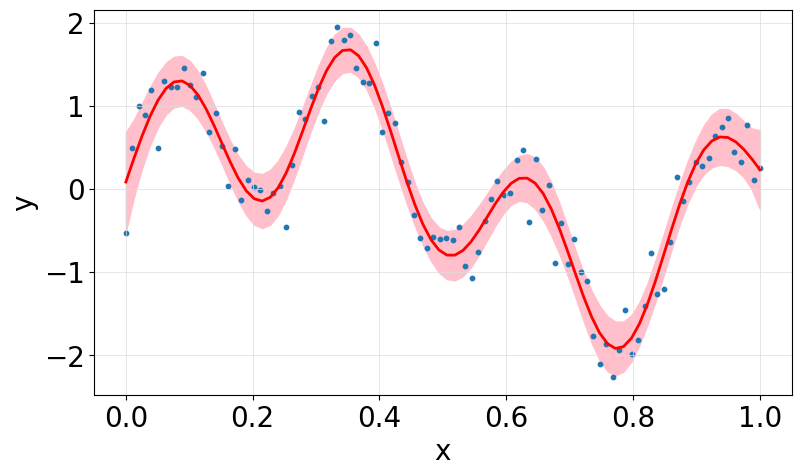

In [28]:
fig, ax = plt.subplots(1,1, figsize=(9,5))

mean = np.array(idata.posterior_predictive.f.mean(axis=(0,1)))                # Average over all samples and chains
std = np.array(idata.posterior_predictive.f.std(axis=(0,1), ddof=1)) 

ax.plot(Xnew, mean, c='red', linewidth=2)
ax.fill_between(Xnew.flatten(), mean-3*std, mean+3*std, color="pink", alpha=1)

ax.scatter(x,y,s=10,c="C0")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid(True, color='gainsboro', linestyle='-', linewidth=0.5)
plt.show()

## Another example: the Mauna Loa dataset

This example is strongly inspired by an example in the PyMC documentation pages.

In [29]:
url = "https://raw.githubusercontent.com/JorisDeRidder/DataAnalysisInPhysicsAndAstronomy/main/Datasets/CO2_MaunaLoa_monthly.csv"
data = pd.read_csv(url)
data.head()
t = data['year'].values
y = data['co2'].values

The following dataset shows why our planet risks to become uninhabitable if we do not act (very) fast:

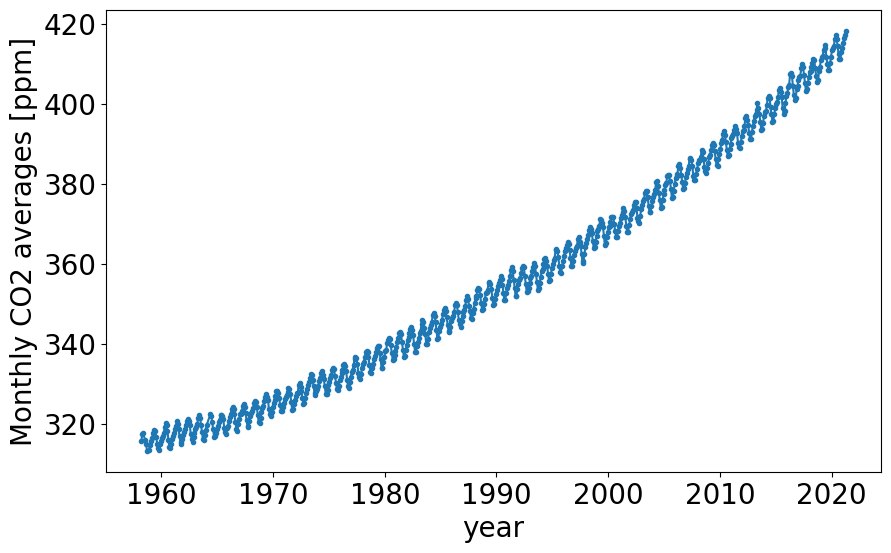

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(data.year, data.co2, marker='o', markersize=3)
ax.set_xlabel("year")
ax.set_ylabel("Monthly CO2 averages [ppm]")
plt.show()

The following model uses a sum of three GPs to capture the periodic trend, the long-term trend, and small/medium term irregularities. Cf the [PyMC documentation page](https://docs.pymc.io/api/gp/cov.html) on available covariance functions for a Gaussian Process. Note: depending on the dataset you use and the laptop available, the model can be rather slow, in particular for M1 Macbooks.

In [ ]:
with pm.Model() as model:
    
    # The slowly varying long-term trend
    
    etaTrend      = pm.HalfCauchy("etaTrend", beta=2, initval=2.0)
    lambdaExpQuad = pm.Gamma("lambdaExpQuad", alpha=4, beta=0.1)
    covTrend      = etaTrend**2 * gp.cov.ExpQuad(1, lambdaExpQuad)
    
    myGPtrend = pm.gp.Marginal(cov_func=covTrend)

    # Periodic component: PyMC3 has only one covariance function available to model periodic data
    # The periodicity may not remain exact, so we multiply by a Matern52 function to take into account
    # a decay of the exact periodic component. We put a long decay time, however, because we don't expect
    # this to happen any soon.
    
    period         = pm.Normal("period",          mu=1, sigma=0.05)
    lambdaPeriodic = pm.Gamma("lambdaPeriodic",   alpha=4, beta=3)
    etaPeriodic    = pm.HalfCauchy("etaPeriodic", beta=2, initval=1.0)
    lambdaMatern52 = pm.Gamma("lambdaMatern52",   alpha=10, beta=0.075)
    covSeasonal    = etaPeriodic**2 * gp.cov.Periodic(1, period, lambdaPeriodic) * gp.cov.Matern52(1, lambdaMatern52)
    
    myGPseasonal = pm.gp.Marginal(cov_func=covSeasonal)
    
    # On top of all these perodicities and trends, there is also noise. It's unclear whether it's pure
    # white noise, so we also add a Matern32 process to add noise on a somewhat longer time scale.
    
    etaNoise       = pm.HalfNormal("etaNoise", sigma=0.5, initval=0.05)
    lambdaMatern32 = pm.Gamma("lambdaNoise", alpha=2, beta=4)
    #sigma          = pm.HalfNormal("sigma", sigma=0.25, initval=0.05)                                     # There is currently a bug (#6673) in gp that causes the following line to fail with gp.cov.WhiteNoise.
    #covNoise       = etaNoise**2 * gp.cov.Matern32(1, lambdaMatern32) + gp.cov.WhiteNoise(sigma)
    covNoise       = etaNoise**2 * gp.cov.Matern32(1, lambdaMatern32)

    # The Gaussian process is a sum of these components
    
    myGP = myGPseasonal + myGPtrend

    # The likelihood
    
    likelihood = myGP.marginal_likelihood("y", X=t.reshape((len(t),1)), y=y, sigma=covNoise)

    # Find the MAP values 
    
    MAP = pm.find_MAP(include_transformed=True)

    # Sample

    idata = pm.sample(500, chains=2, cores=4, return_inferencedata=True)

Use the GP to predict the posterior mean and the posterior variance between the years 2015 and 2030.

In [ ]:
tnew = np.linspace(2015, 2030, 15*12*2)[:,None]
mu, var = myGP.predict(tnew, point=MAP, diag=True)
sigma = np.sqrt(var)

Plot the mean, and the 1-sigma and 3-sigma intervals.

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.scatter(data.year, data.co2, s=30)
ax.plot(tnew, mu, c="red")
ax.fill_between(tnew.ravel(), mu-sigma, mu+sigma, color="red", alpha=0.1)
ax.fill_between(tnew.ravel(), mu-3*sigma, mu+3*sigma, color="red", alpha=0.1)
ax.set_xlabel("year")
ax.set_ylabel("Monthly CO2 averages [ppm]")
ax.set_xlim(2015, 2030)
ax.set_ylim(390,)
plt.show()